In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

arquivo = 'imd_notas.xlsx'
excel = pd.ExcelFile(arquivo)
print(excel.sheet_names)
dados = excel.parse(0)



['Notas']


In [49]:
#1)

# - Em cada disciplina é feito a contagem do total de alunos reprovados, sem considerar quem reprovou e não foi aprovado na 
# mesma disciplina em um semestre seguinte, depois dividi esse total pelo número de aprovações.


#A

sum_total_reprovacoes=0
sum_total_aprovacoes=0

for j in dados['disciplina_ID'].unique(): #disciplinas
    dados_disc = dados.loc[(dados['disciplina_ID'] == j)]
    dados_apro = dados_disc.loc[(dados['status.disciplina'] == 'Aprovado')] #lista de aprovados    
    dados_apro_repr = dados_disc.merge(dados_apro, left_on='a_ID', right_on='a_ID', how='outer')    
    
    total_reprovacoes = len(dados_apro_repr.loc[(dados_apro_repr["status.disciplina_x"]=="Reprovado") & (dados_apro_repr["status.disciplina_y"]=="Aprovado")])
    total_aprovacoes = len(dados_apro_repr.loc[(dados_apro_repr["status.disciplina_x"]=="Aprovado")]["a_ID"])
    
    sum_total_reprovacoes = sum_total_reprovacoes+total_reprovacoes
    sum_total_aprovacoes = sum_total_aprovacoes+total_aprovacoes
    
    print("Disciplina id ", j, " = ", (total_reprovacoes+total_aprovacoes)/total_aprovacoes)


# - Média considerando todas as disciplinas 

#B
print("\n\nGeral = ", (sum_total_reprovacoes+sum_total_aprovacoes)/sum_total_aprovacoes )

Disciplina id  0  =  1.2655826558265582
Disciplina id  1  =  1.0269058295964126
Disciplina id  2  =  1.1267605633802817
Disciplina id  3  =  1.3333333333333333
Disciplina id  4  =  1.0313111545988258
Disciplina id  5  =  1.3549618320610688
Disciplina id  6  =  1.0889679715302492


Geral =  1.136623748211731


In [50]:
#2

# - Para ter mais precisão dos dados, considerei os 20 CEPs com mais alunos e calculei a taxa de aprovação
# em cada um, que pode variar de 0% até 100%.
# - O CEP 0 representa os alunos sem CEP registrado na tabela.

dados2 = dados
dados2['status.disciplina'] = dados2['status.disciplina'].replace(['Aprovado'], 1) # Altera o status para Aprovado
dados2['status.disciplina'] = dados2['status.disciplina'].replace(['Reprovado'], 0) # Altera o status para Reprovado
dados2 = dados[dados['CEP'].isin(dados['CEP'].value_counts()[0:20].index)]

dados_taxa_apro = pd.pivot_table(dados2, values='status.disciplina', index=['CEP'], aggfunc=np.mean)
dados_taxa_apro["numero_ocorrencias_cep"] = dados['CEP'].value_counts()[0:20].values
dados_taxa_apro.rename(columns={'status.disciplina': 'taxa_aprovacao'}, inplace=True)
dados_taxa_apro['taxa_aprovacao'] = dados_taxa_apro['taxa_aprovacao']*100

print(dados_taxa_apro.sort_values('taxa_aprovacao', ascending=[0]))



          taxa_aprovacao  numero_ocorrencias_cep
CEP                                             
59700000       93.333333                      20
59550000       81.132075                      21
59650000       80.000000                      20
59151400       80.000000                      53
59152600       74.074074                      39
59347000       70.370370                      22
59151250       62.962963                      66
59190000       61.904762                      27
59290000       58.715596                      25
59162000       57.142857                      30
59173000       57.142857                      28
59570000       56.976744                      21
0              56.055363                     289
59182000       54.545455                      27
59200000       52.000000                      27
59380000       50.000000                      22
59115190       50.000000                      86
59280000       46.969697                      25
59575000       41.02

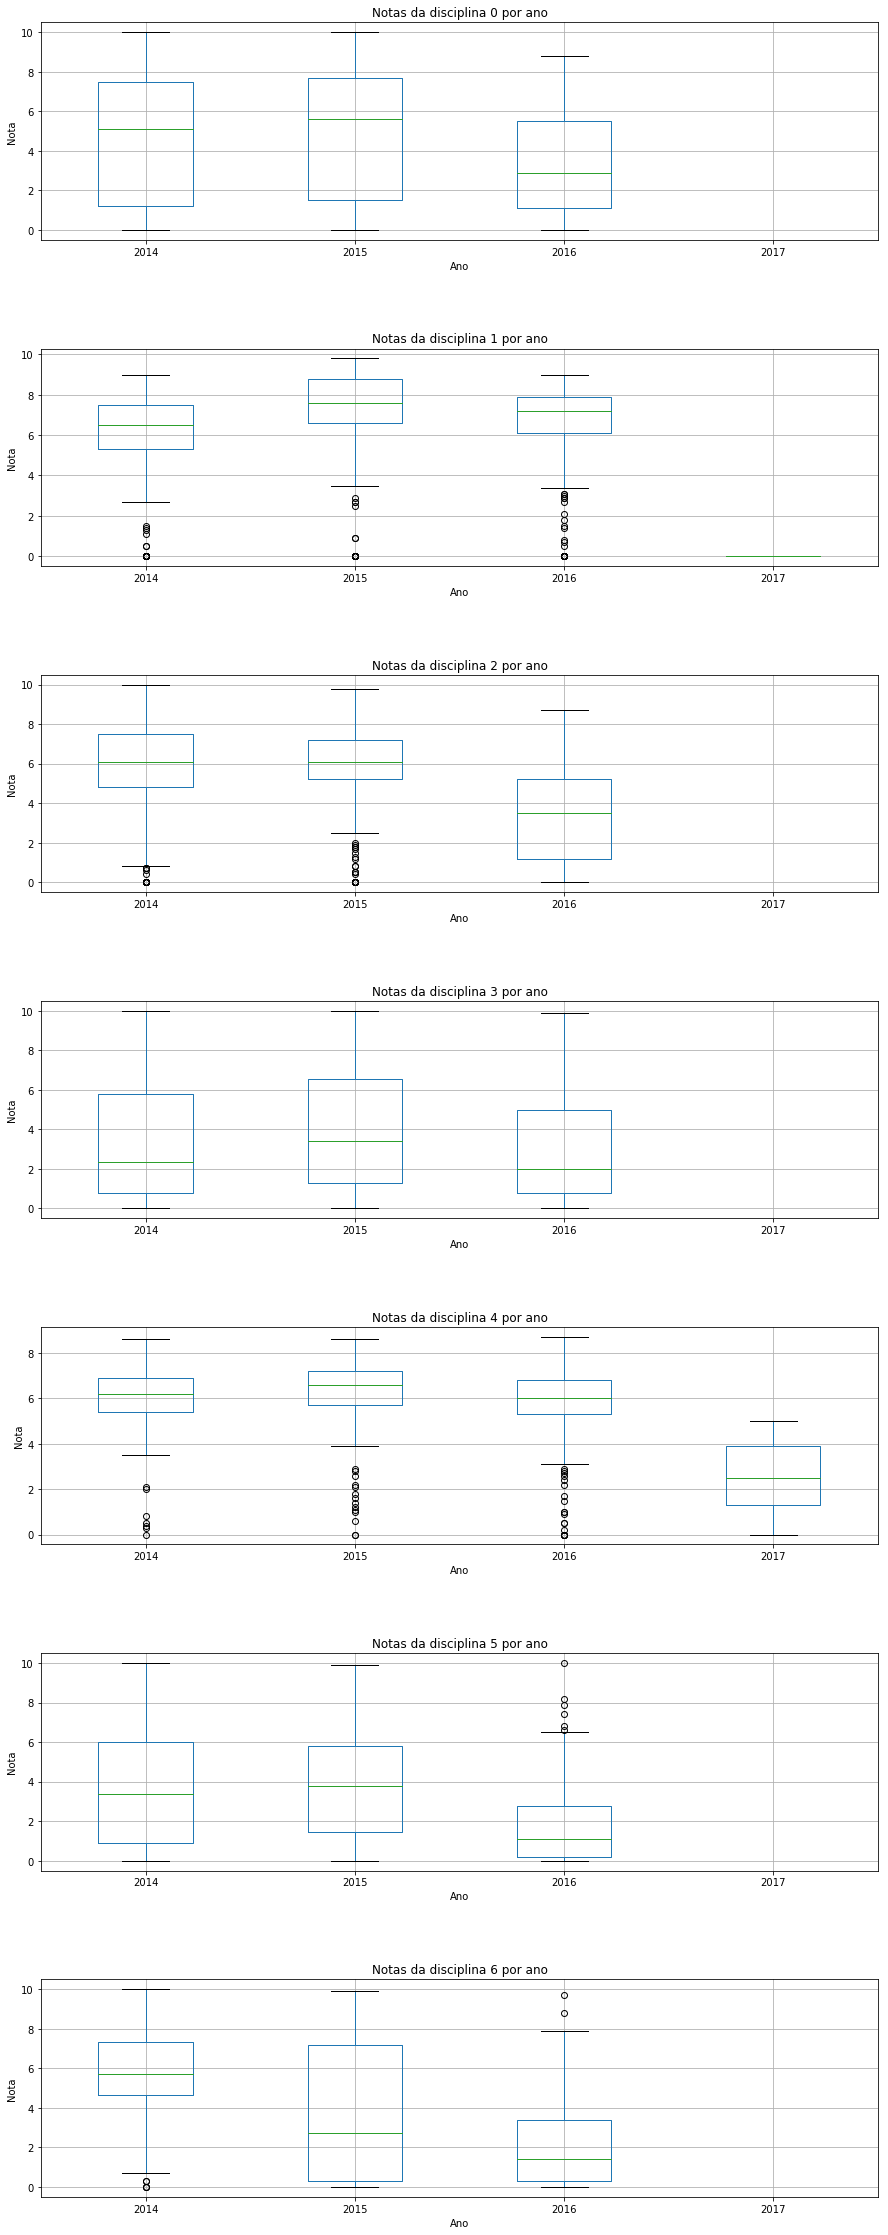

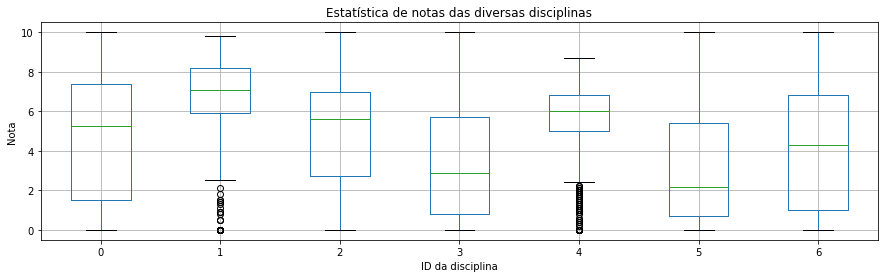

In [51]:
#3
#A

# Criei um gráfico para cada disciplina e preenchi as notas em cada ano.
# A coluna X representa os anos e a coluna Y as notas


list_ano = dados['ano_disciplina'].unique()
list_disciplinas = dados['disciplina_ID'].unique()
fig3a, axes3a = plt.subplots(nrows=len(list_disciplinas), ncols=1, figsize=(15,40))
dados3a = pd.DataFrame()
count1 = 0

for disc in list_disciplinas:
    dados3a.drop(dados3a.index, inplace=True)
    axes3a[count1].title.set_text('Notas da disciplina '+str(disc)+' por ano')
    
    for ano in list_ano:
        dados3a[ano] = pd.Series(dados.loc[(dados['disciplina_ID']==disc) & (dados['ano_disciplina']==ano)]['nota'].tolist())

    dados3a.boxplot(ax=axes3a[count1])    
    axes3a[count1].set_xlabel('Ano')
    axes3a[count1].set_ylabel('Nota')
    count1 = count1+1
    
fig3a.subplots_adjust(hspace=.5)

# Criei um gráfico para todas as disciplinas, sem considerar os anos.
# Cada item da coluna X é uma disciplina e na coluna Y estão as notas.

#B
fig3b = plt.figure(figsize=(15,4))
df = pd.DataFrame()

for disc in list_disciplinas:
    df[disc]=pd.Series(dados.loc[dados['disciplina_ID'] == disc]['nota'].tolist())

ax3b = df.boxplot()
ax3b.set_xlabel('ID da disciplina')
ax3b.set_ylabel('Nota')
plt.title('Estatística de notas das diversas disciplinas')
plt.show()



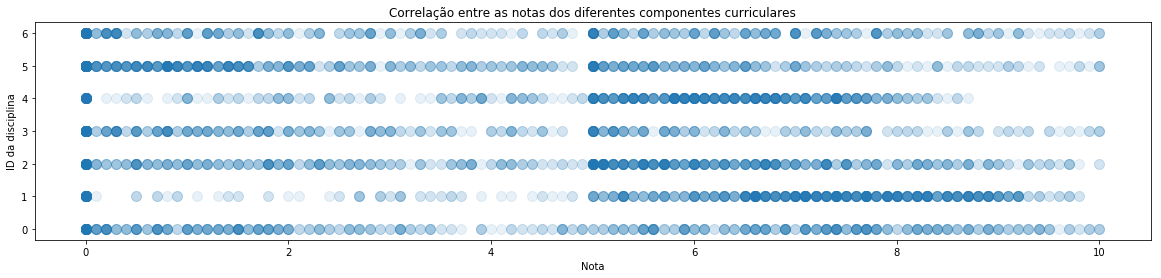

In [42]:
#4

# Criei um gráfico de dispersão com as notas na coluna X e os identificadores das disciplinas na coluna Y.

fig2 = plt.figure(figsize=(20,4))
plt.title('Correlação entre as notas dos diferentes componentes curriculares')
plt.xlabel('Nota')
plt.ylabel('ID da disciplina')
X = dados['nota']
Y = dados['disciplina_ID']
plt.scatter(X,Y, alpha=0.1, s=100)

plt.show()


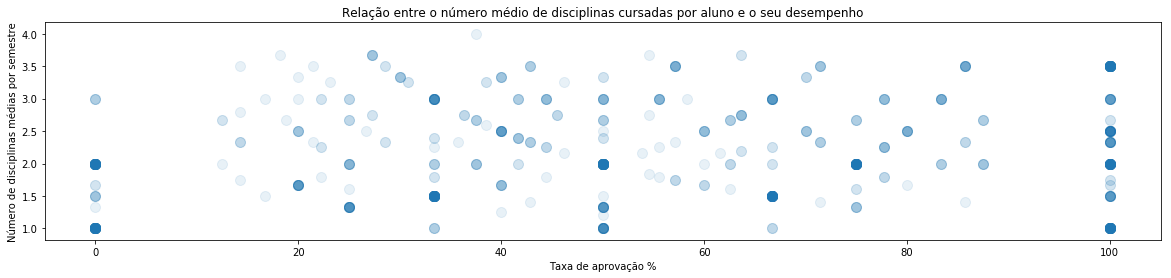

In [52]:
#5
# - Criei uma tabela com o ID de cada aluno, a taxa de aprovação e a média da quantidade de disciplinas que ele 
# cursa por semestre.
# - No gráfico de dispersão coloquei na coluna Y a média de disciplinas por semestre.
# - Na coluna X coloquei a taxa de aprovação do aluno.

dados["num_aux"] = 1  #cálculo do número de disciplinas cursadas pelo aluno
num_disciplinas = dados
num_disciplinas = num_disciplinas.groupby(['a_ID'])['num_aux'].sum().reset_index().set_index("a_ID")

num_semestres = pd.DataFrame() # cálculo do número de semestres cursados
num_semestres["num_semestres"] = dados.drop_duplicates(['a_ID', 'ano_disciplina', 'periodo_disciplina'])['a_ID'].value_counts()
num_semestres = num_semestres.reset_index().set_index("index")
num_semestres.index.names = ['a_ID']

taxa_aprov_alun = dados #cálculo da taxa de aprovação do aluno
taxa_aprov_alun['status.disciplina'] = taxa_aprov_alun['status.disciplina'].replace(['Aprovado'], 1) # Altera o status para Aprovado
taxa_aprov_alun['status.disciplina'] = taxa_aprov_alun['status.disciplina'].replace(['Reprovado'], 0) # Altera o status para Reprovado
taxa_aprov_alun = taxa_aprov_alun.groupby(['a_ID'])['status.disciplina'].mean()

num_disciplinas["media_disciplinas"] = num_disciplinas["num_aux"]/num_semestres["num_semestres"] # média de disciplinas

fig5 = plt.figure(figsize=(20,4))


Y = num_disciplinas["media_disciplinas"]
X = taxa_aprov_alun*100
plt.scatter(X,Y, alpha=0.1, s=100)

plt.title("Relação entre o número médio de disciplinas cursadas por aluno e o seu desempenho")
plt.ylabel("Número de disciplinas médias por semestre")
plt.xlabel("Taxa de aprovação %")

plt.show()



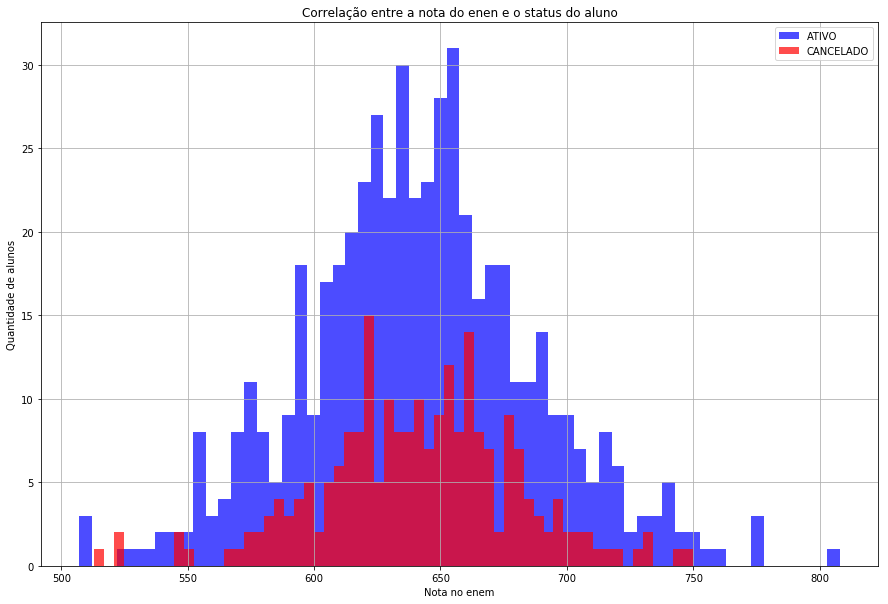

In [44]:
#6

# Creie um histograma com os alunos ativos(azul) e com matrícula cancelada(vermelho)
# A coluna Y representa a quantidade de alunos
# A coluna X representa a nota no enem

fig6 = plt.figure(figsize=(15,10))

#d = pd.pivot_table(df,index='ID',columns='subindex',values='count').fillna(0)

ativo = dados.loc[dados['status'] == "ATIVO"].drop_duplicates(subset='a_ID')
cancelado = dados.loc[dados['status'] == "CANCELADO"].drop_duplicates(subset='a_ID')

ativo["enen-nota"].hist(color="blue", label="ATIVO", bins=60, alpha=0.7)
cancelado["enen-nota"].hist(color="red", label="CANCELADO", bins=60, alpha=0.7)

plt.legend()
plt.xlabel('Nota no enem')
plt.ylabel('Quantidade de alunos')
plt.title("Correlação entre a nota do enen e o status do aluno")
plt.show()



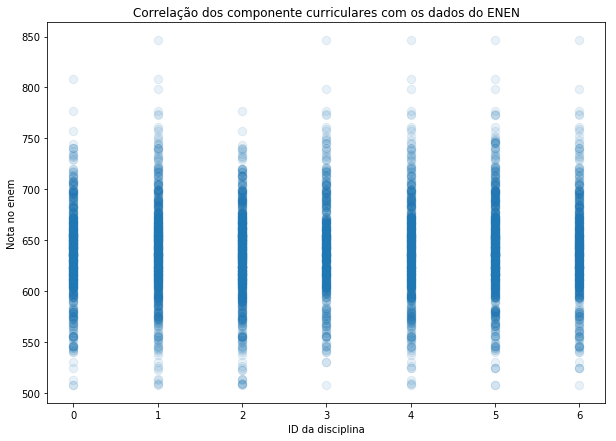

In [47]:
#7

# - Criei uma gráfico de disperção, coloquei na coluna Y a nota do enem e na coluna X o ID da disciplina que o aluno
# está matriculado

fig2 = plt.figure(figsize=(10,7))
Y = dados['enen-nota']
X = dados['disciplina_ID']
plt.scatter(X,Y, alpha=0.1, s=70)
plt.xlabel('ID da disciplina')
plt.ylabel('Nota no enem')
plt.title("Correlação dos componente curriculares com os dados do ENEN")
plt.show()
